<h1 style="text-align: center;">Generating a MIDI music file from a time series:<br>A mostly harmless and quite fun routine</h1>

<p style="text-align: center"> Created by Rémy Lapere. November 2022.</p>

Music is numbers. A time series is numbers. A time series is music.

Based on this observation, the present notebook offers an easy way to convert a time series, or combination of time series, into a music score in MIDI format. This notebook is largely useless, definitely very nerdy, but honestly quite fun. It could also help convey messages about the changing climate to a broader audience by leveraging emotions rather than cartesian reasoning.

<p align="center">
  <img src="./data/snap_gb.png" width="600" height="400">
<figcaption style="text-align: center"><i>Arctic sea ice environments in a changing climate</i>, a symphony in Cminor</figcaption>
</p>

In [1]:
# Install a pip package in the current Jupyter kernel if needed
# only run this once then comment out
# This may take some time but it is necessary to be able to run the notebook in case
# you do not have all the necessary libraies installed

#import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install miditime
#!{sys.executable} -m pip install pygame
#!{sys.executable} -m pip install python-vlc

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import vlc
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['figure.dpi'] = 200

## Custom functions

Below is a series of custom functions designed to transform data into an acceptable format for conversion into a `MIDI` file. Additional functions are created to play the music directly from the notebook.

#### Rescale original values into acceptable audible range

In [3]:
def rescale(inxr,mn,mx,flip=False):
    import pandas as pd
    """
    function to rescale original data to the range of authorized pitch
    """
    
    mini = inxr.min()
    maxi = inxr.max()

    # normalize data to [0,1]
    inxr_ = (inxr-mini)/(maxi-mini)

    # apply a mapping to the range of authorized min/max pitch
    inxr_ = mn+inxr_*(mx-mn)

    # if you want to associate increasing temperature with lower pitch notes
    if flip==True:
        inxr_ = mn-inxr_+mx

    # make it an integer type because MIDI only handles semitones
    inxr_ = inxr_.astype(int)

    # store notes into a data set along with time steps
    df_ = pd.DataFrame({'val':inxr_,'step':range(len(inxr_))})
    
    return df_

#### Remap values into allowed chord notes

In [4]:
def _to_chords_(df, key, minpitch, maxpitch):
    import numpy as np
    """
    function to map the original notes to the defined key
    """
    notes = range(len(np.arange(minpitch,maxpitch+1,1)))
    notes_ = np.arange(minpitch,maxpitch+1,1)
    dom = np.mod(notes,12)==key[0]
    tir = np.mod(notes,12)==key[1]
    qui = np.mod(notes,12)==key[2]
    sev = np.mod(notes,12)==key[3]
    auth = dom+tir+qui+sev
    auth_notes = notes_[auth]
    notin = df.val.values
    i=0
    for nn in notin:
        dist = np.abs(auth_notes-nn)
        tru_note = auth_notes[np.argmin(dist)]
        notin[i] = tru_note
        i=i+1
    df['val'] = notin
    return df

#### Aggregate consecutive notes, compute duration...

In [5]:
def extract_sdt(indata, kkeys, freq, minpitch, maxpitch):
    import numpy as np
    import pandas as pd
    """
    function to aggregate consecutive notes
    and includes info on duration/velocity
    """
    didif = [indata['step'].values[0]]
    indata = _to_chords_(indata, kkeys, minpitch, maxpitch)
    for i in np.arange(1,len(indata.val.values)):
        if indata['val'].values[i]==indata['val'].values[i-1]:
            didif = np.append(didif,indata['step'].values[i-1])
        else:
            didif = np.append(didif,indata['step'].values[i])
    indata['dif'] = didif
    steps = indata.groupby(['dif','val'],as_index=False).count().step.values
    vals = (indata.groupby(['dif','val'],as_index=False).mean().val.values).astype(int)
    new_df = pd.DataFrame({'note':vals,
                       'steps':np.cumsum(steps)-np.min(np.cumsum(steps)),
                       'duration':np.append(steps[1:],2),
                      'force':np.repeat(127,len(steps))})
    for j in np.arange(1,len(new_df.note.values)):
        if new_df.note.values[j] == new_df.note.values[j-1]:
            new_df.steps[j] = new_df.steps.values[j-1]
    dur = new_df.groupby(['steps'],as_index=False).sum().duration.values
    new_df = new_df.drop_duplicates(['steps','note'])
    new_df.duration = dur
    new_df['force'] = np.linspace(100,126,len(dur)).astype(int)
    new_df['steps'] = (new_df['steps'].values*freq).astype(int)
    new_df['duration'] = (new_df['duration'].values*freq).astype(int)
    new_df = new_df[['steps','note','force','duration']]
    return new_df

#### Apply the chord progression defined by the bass line on the melody tracks

In [6]:
def apply_progression(indata,freq,freqbase,reperes,keys,chords,minpitch,maxpitch):
    import numpy as np
    import pandas as pd
    """
    apply the chord progression as defined by the variable chosen a bass line
    """    
    
    df_ = indata.copy()
    
    j = 0
    for r in reperes:
        keyloc = chords[str(int(keys[j]%12))]
        keyloc = np.append(keyloc[0],keyloc)
        if j <len(reperes)-1:
            dfloc = df_[(df_.step.values>=r) & (df_.step.values<reperes[j+1])]
            inloc = _to_chords_(dfloc, keyloc, minpitch, maxpitch)
            df_[(df_.step.values>=r) & (df_.step.values<reperes[j+1])] = inloc.astype(int)
        else:
            dfloc = df_[(df_.step.values>=r)]
            inloc = _to_chords_(dfloc, keyloc, minpitch, maxpitch)
            df_[df_.step>=r] = inloc.astype(int)
        j = j+1

    didif = [df_['step'].values[0]]
    for i in np.arange(1,len(df_.val.values)):
        if df_['val'].values[i]==df_['val'].values[i-1]:
            didif = np.append(didif,df_['step'].values[i-1])
        else:
            didif = np.append(didif,df_['step'].values[i])
    df_['dif'] = didif
    steps = df_.groupby(['dif','val'],as_index=False).count().step.values
    vals = (df_.groupby(['dif','val'],as_index=False).mean().val.values).astype(int)
    new_df = pd.DataFrame({'note':vals,
                       'steps':np.cumsum(steps)-np.min(np.cumsum(steps)),
                       'duration':np.append(steps[1:],2),
                      'force':np.repeat(127,len(steps))})
    for j in np.arange(1,len(new_df.note.values)):
        if new_df.note.values[j] == new_df.note.values[j-1]:
            new_df.steps[j] = new_df.steps.values[j-1]
    dur = new_df.groupby(['steps'],as_index=False).sum().duration.values
    new_df = new_df.drop_duplicates(['steps','note'])
    new_df.duration = dur
    new_df['force'] = np.linspace(100,126,len(dur)).astype(int)
    new_df['steps'] = (new_df['steps'].values*freq).astype(int)
    new_df['duration'] = (new_df['duration'].values*freq).astype(int)
    new_df = new_df[['steps','note','force','duration']]
    return new_df

#### Convert the finalized data into a MIDI file

In [7]:
def blockPrint():
    import sys,os
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    import sys,os
    sys.stdout = sys.__stdout__

def to_midi(infiles,nm):
    import numpy as np
    import pandas as pd
    from miditime.miditime import MIDITime
    """
    function to convert the data to MIDI file
    """
    blockPrint()
    mymidi = MIDITime(350, nm+'.mid') # 160 is the tempo
    for infile in infiles:
        music = np.array(pd.read_csv(infile,skiprows=1,header=None,index_col=0)).tolist()
        # Add a track with those notes
        mymidi.add_track(music)
    # Output the .mid file
    mymidi.save_midi()
    enablePrint()

#### Play the music directly from the notebook

In [8]:
def play_music(music_file):
    import pygame
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        print("Music file %s is playing!" % music_file)
    except pygame.error:
        print("File %s not found! (%s)" % (music_file, pygame.get_error()))
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)

        
def launch_music(music_file):
    import pygame
    freq = 44100    # audio CD quality
    bitsize = -16   # unsigned 16 bit
    channels = 2    # 1 is mono, 2 is stereo
    buffer = 1024    # number of samples
    pygame.mixer.init(freq, bitsize, channels, buffer)

    # optional volume 0 to 1.0
    pygame.mixer.music.set_volume(1.0)

    try:
        play_music(music_file)
    except KeyboardInterrupt:
        pygame.mixer.music.fadeout(1000)
        pygame.mixer.music.stop()
        raise SystemExit

## Step 1: load data

Here I use two example time series I extracted beforehand from `CMIP6` but this can work with any time series/combination of time series. 

In [9]:
# yearly average sea surface temperature north of 60N in CMIP6 SSP585 scenario (1850-2099)
tos = pd.read_csv('./data/tos.csv')
# yearly average sea ice area extent in the northern hemisphere in CMIP6 SSP585 scenario (1850-2099)
sia = pd.read_csv('./data/sia.csv')
sia

,year,siarean
0,1850,11.325597
1,1851,11.047202
2,1852,11.177764
3,1853,11.171661
4,1854,10.973987
...,...,...
246,2096,6.062725
247,2097,6.149334
248,2098,5.692888
249,2099,5.248956


## Step 2: resample to create bass line and melody

Let's resample the data to obtain the desired variability frequency. Here I take sea ice extent averaged every 5 years to be used as bass line, and SST averaged every 1 year for the melody.

In [10]:
w = 5
siaf = np.zeros(len(sia.siarean.values)-1)
for i in range(int(len(siaf)/w)):
    siaf[i*w:(i+1)*w] = np.mean(sia.siarean.values[i*w:(i+1)*w])
    
w = 1
tosf = np.zeros(len(tos.tos.values))
for i in range(int(len(tosf)/w)):
    tosf[i*w:(i+1)*w] = np.mean(tos.tos.values[i*w:(i+1)*w])

## Step 3: rescale data into acceptable pitch range

Let's rescale the data between min and max authorized pitch to make it audible. Typically, anything below 20 or above 100 is inaudible for the human ear. If you compose for your dog or dolphin you might want to change that scale...

In [11]:
# flip argument is to make increasing trend sound lower and vice versa
# you might want to use this argument depending on the message you want to convey with the using
# e.g. warmer temperatures are not a good sign so you would want increasing trends to sound lower not higher
sia_ = rescale(siaf,24,72,flip=False) 
tos_ = rescale(tosf,48,84,flip=False)

## Step 4: chord progression definition

In the next cell we will define the chord progression we want to have in our song. In this example, I want my chords to be C,Dm,F,Gm. I do not constrain the order in which the chords appear, it is dictated by the values in the bass line time series. This will provide a little diversity to the song, make it less monotonous.

In `MIDI` format, each integer corresponds to a semitone. Therefore the distance between two octaves is 12. 0mod12 corresponds to C, 2mod12 is D, 4mod12 is E, etc... For the chord progression I want, my fundamentals are then C,D,F,G, i.e. 0,2,5,7 in terms of numbers (*auth_fund* below). The corresponding full chords are stored in dict_keys. In the next steps, the goal is to approximate the data with the closest authorized note to make it sound better than the raw data, which is not supposed to sound wit particular harmony. This is of course highly tunable.

In [12]:
auth_fund = [0,2,5,7]
dict_keys = dict({'0':[0,4,7],'2':[2,5,9],'5':[5,9,0],'7':[7,10,2]})

## Step 5: extract chords progression from bass line data and apply it to melody data

In [13]:
bassline = extract_sdt(sia_,auth_fund,1,36,96) # create bass line from the sia_ data
prog_steps = np.unique(bassline.steps.values) # chords progression from bass line
keyp = bassline.note.values%12 # fundamental note of the bass line

In [14]:
# apply the chord progression to the "melody" data, here tos_
# duplicate this step for as many melody lines as you want
tosp = apply_progression(tos_,1,1,prog_steps,keyp,dict_keys,24,72) 

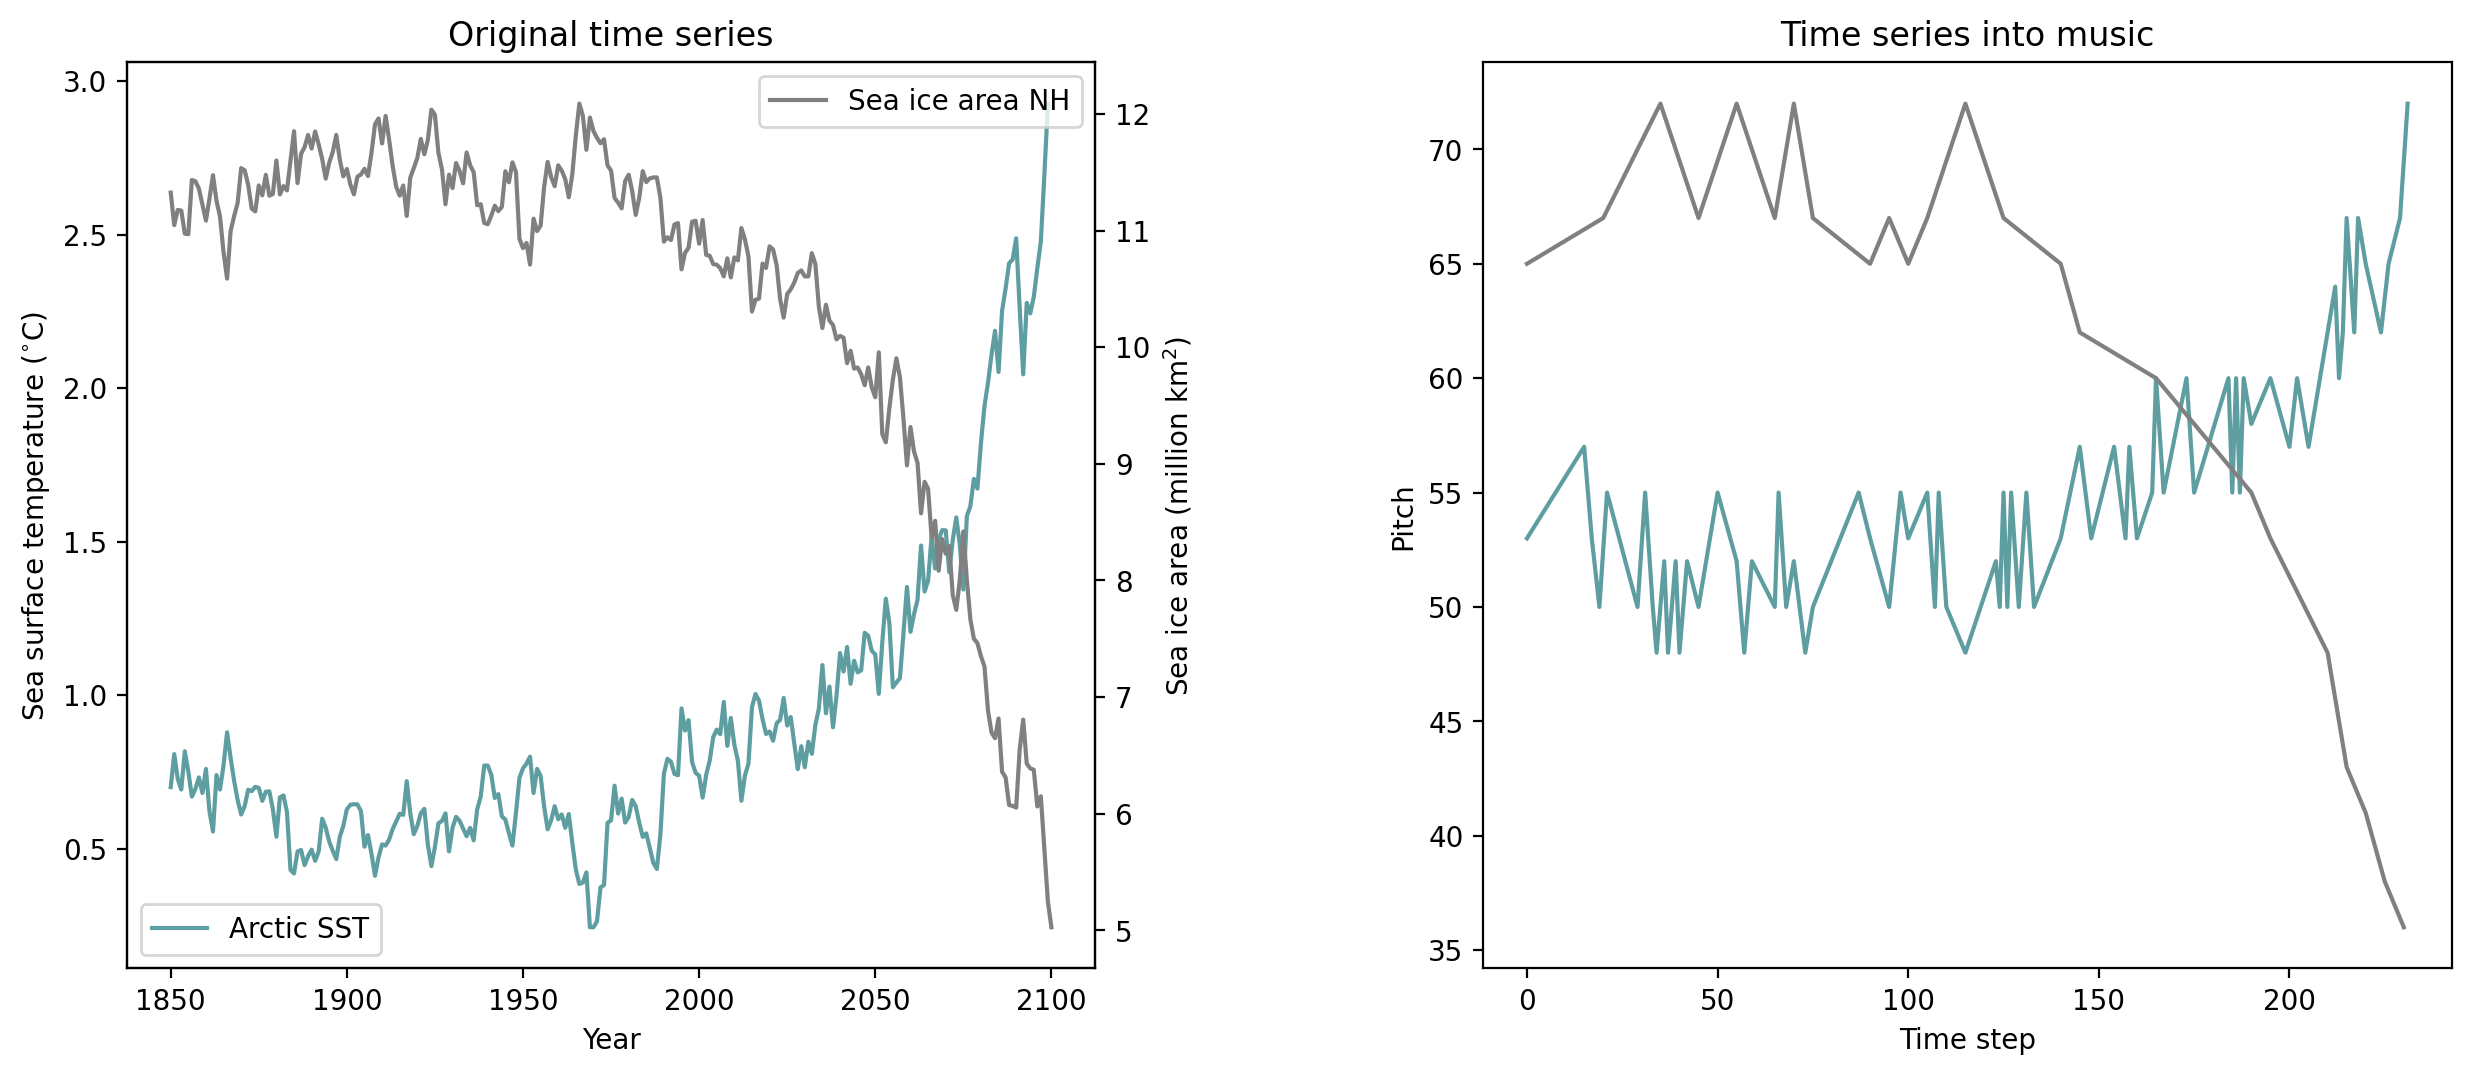

In [15]:
# plot the data before and after transformation to make sure all is consistent
fig = plt.figure(figsize=(15,6))

ax = plt.subplot(121)
ax.plot(tos.year,
        tos.tos,
        color='cadetblue',
        label='Arctic SST')
ax.set_ylabel('Sea surface temperature ($^{\circ}$C)')
plt.legend(loc=3)

ax_ = ax.twinx()
ax_.plot(sia.year,
         sia.siarean,
         color='gray',
         label='Sea ice area NH')
ax.set_title('Original time series')
ax_.set_ylabel('Sea ice area (million km$^2$)')
ax.set_xlabel('Year')
plt.legend()

ax1 = plt.subplot(122)
ax1.plot(tosp.steps,
         tosp.note,
         color='cadetblue')
ax1.plot(bassline.steps,
         bassline.note,
         color='gray')
ax1.set_title('Time series into music')
ax1.set_ylabel('Pitch')
ax1.set_xlabel('Time step')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [16]:
# save both tracks into csv files and then into a single MIDI file
tosp.to_csv('tosp')
bassline.to_csv('siap')
to_midi(['tosp','siap'],'merged')

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Music file merged.mid is playing!


In [17]:
# play the created MIDI file in Python
# If you have a software to do just that, you'd better use it instead of Python
launch_music('merged.mid')

The result may not sound super cool just yet, but as you include more tracks and use an external midi software such as `GarageBand`, the result can be much nicer. As an example, below you can play a track I created with this script and `GarageBand` using zooplankton, arctic sea ice area and concentration, and sea surface temperature from `CMIP6`.

In [18]:
# Same as above, does not work on the UGA server
p = vlc.MediaPlayer("arctic_ocean.mp3")
p.play()

0

In [19]:
p.stop()

[00007fc49a5bfc10] cache_read stream error: cannot pre fill buffer
[00007fc49a34d950] mjpeg demux error: cannot peek
